In [19]:
import segmentation_models as sm
import matplotlib.pyplot as plt
import cv2
import numpy as np
import os
from pycocotools.coco import COCO
import random

In [20]:
import gc

gc.collect()

1242

In [21]:
base_folder = 'C:/Users/chuck/OneDrive/Desktop/Honors/PV-Cell-Segmentation.v1i.coco-segmentation/'
train_img_dir = f'{base_folder}train/raws/'
train_mask_dir = f'{base_folder}train/masks/'

In [22]:
image_dataset = []
mask_dataset = []

for images in os.listdir(train_img_dir):
    image = cv2.imread(train_img_dir+'/'+images)
    image = cv2.resize(image, (256, 256))
    image = np.array(image)
    image_dataset.append(image)

for images in os.listdir(train_mask_dir):
    image = cv2.imread(train_mask_dir+'/'+images, 0)
    image = cv2.resize(image, (256, 256))
    image = np.array(image)
    mask_dataset.append(image)


In [23]:
image_dataset = np.array(image_dataset)
mask_dataset = np.array(mask_dataset)

In [24]:
mask_dataset.shape

(292, 256, 256)

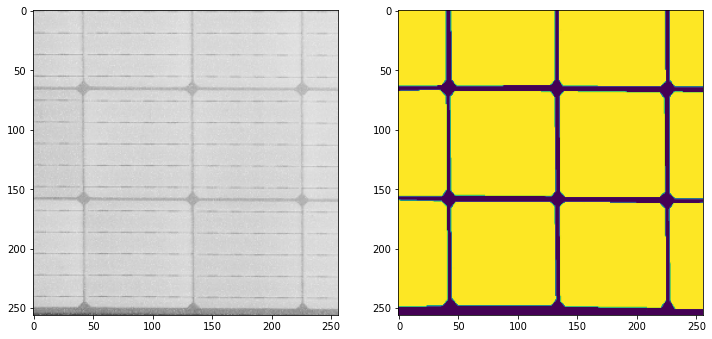

In [25]:
# Sanity check...
image_number = random.randint(0, len(image_dataset))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(image_dataset[image_number])
plt.subplot(122)
plt.imshow(mask_dataset[image_number])
plt.show()

In [26]:
labels = []

for mask in mask_dataset:
    _, mask = cv2.threshold(mask, 200, 255, cv2.THRESH_BINARY)
    label = mask//200
    labels.append(label)

Unique labels in label dataset are:  [0 1]


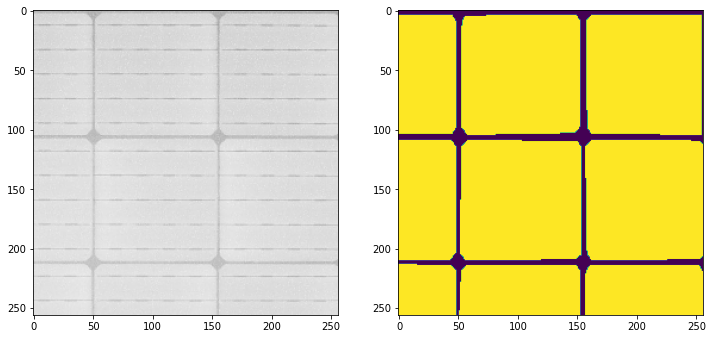

In [27]:
print("Unique labels in label dataset are: ", np.unique(labels))

#Another Sanity check...
image_number = random.randint(0, len(image_dataset))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(image_dataset[image_number])
plt.subplot(122)
plt.imshow(labels[image_number][:,:])
plt.show()

In [28]:
from tensorflow.keras.utils import to_categorical

print(np.shape(labels))
n_classes = len(np.unique(labels)) # 23 classes...
labels_cat = to_categorical(labels, num_classes=n_classes) # one hot encoding the labels...
print(n_classes)
print(np.shape(labels_cat))
print(np.shape(image_dataset))

(292, 256, 256)
2
(292, 256, 256, 2)
(292, 256, 256, 3)


In [29]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, labels_cat, test_size = 0.20, random_state = 42) # train test split for data...

In [30]:
# using weights from pretained resnet model...
BACKBONE = 'resnet34' 
preprocess_input = sm.get_preprocessing(BACKBONE)

In [31]:
# preprocess input...
X_train_prepr = preprocess_input(X_train)
X_test_prepr = preprocess_input(X_test)

In [32]:
# define model...
model_resnet_backbone = sm.Unet(BACKBONE, encoder_weights='imagenet', classes=n_classes, activation='softmax')

In [33]:
# accuracy as metrics, adam optimizer and loss function that needs to be optimized is categorical crossentropy as its a multiclass classification problem...
metrics=['accuracy']
model_resnet_backbone.compile(optimizer='adam', loss='categorical_crossentropy', metrics=metrics)

In [34]:
model_resnet_backbone.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data (InputLayer)              [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 bn_data (BatchNormalization)   (None, None, None,   9           ['data[0][0]']                   
                                3)                                                                
                                                                                                  
 zero_padding2d_34 (ZeroPadding  (None, None, None,   0          ['bn_data[0][0]']                
 2D)                            3)                                                          

In [35]:
# training the model for 10 epochs with batch size of 16...
history = model_resnet_backbone.fit(X_train_prepr, 
          y_train,
          batch_size=16, 
          epochs=3,
          verbose=1,
          validation_data=(X_test_prepr, y_test))

Epoch 1/3
15/15 [==============================] - 105s 7s/step - loss: 0.5606 - accuracy: 0.7788 - val_loss: 2917.6055 - val_accuracy: 0.2217
Epoch 2/3
15/15 [==============================] - 112s 8s/step - loss: 0.2375 - accuracy: 0.9338 - val_loss: 2266.1494 - val_accuracy: 0.2218
Epoch 3/3
15/15 [==============================] - 119s 8s/step - loss: 0.1443 - accuracy: 0.9617 - val_loss: 0.4492 - val_accuracy: 0.8202


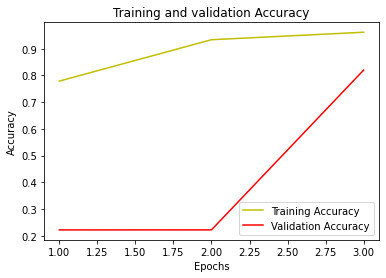

In [36]:
# plotting train and val accuracy in each epoch...
history = history
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, 'y', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [39]:
# model_resnet_backbone.save('models/resnet_backbone.hdf5')

In [40]:
from tensorflow.keras.models import load_model
model = load_model('models/resnet_backbone.hdf5') # loading model...

In [41]:
# making predictions...
y_pred=model.predict(X_test)
y_pred_argmax=np.argmax(y_pred, axis=3)
y_test_argmax=np.argmax(y_test, axis=3)

2/2 [==============================] - 5s 2s/step


In [42]:
# randomly selecting an image from the test set and making prediction...
test_img_number = random.randint(0, len(X_test))
test_img = X_test[test_img_number]
ground_truth=y_test_argmax[test_img_number]
#test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img, 0)
prediction = (model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]

1/1 [==============================] - 0s 139ms/step


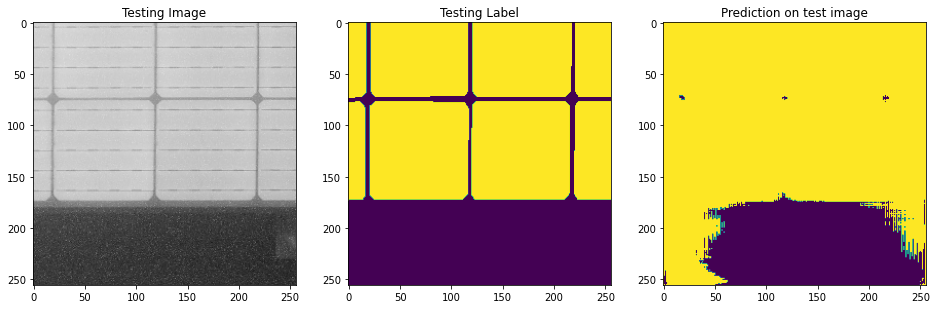

In [43]:
# plotting the real image, test labeled image and predicted labeled image...
plt.figure(figsize=(16, 12))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img)
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth)
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img)
plt.show()